In [45]:
import pandas as pd
import numpy as np

In [46]:
df = pd.read_csv('../data/data.csv')

# Making the first row the header
df.columns = df.iloc[0] 

# Dropping the first row which is now redundant
df = df.drop(df.index[0]).reset_index(drop=True)

# Dropping the 'ID' column
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [47]:
df.rename(columns={'default payment next month':'DEFAULT'}, inplace=True)
df.rename(columns={'PAY_0': 'PAY_STATUS'}, inplace=True)
df.rename(columns={'BILL_AMT1': 'BILL_AMT_LATEST'}, inplace=True)
df.rename(columns={'PAY_AMT1': 'PAY_AMT_LATEST'}, inplace=True)
print(df.columns)

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_STATUS',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT_LATEST',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT_LATEST', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'DEFAULT'],
      dtype='object', name=0)


In [48]:
for i in df.columns:
    df[i] = pd.to_numeric(df[i], errors='coerce')

In [49]:
df['AVG_PAY_AMT_PRIOR'] = (df['PAY_AMT2'] + df['PAY_AMT3'] + df['PAY_AMT4'] + df['PAY_AMT5'] + df['PAY_AMT6'])/5
df['AVG_BILL_AMT_PRIOR'] = (df['BILL_AMT2'] + df['BILL_AMT3'] + df['BILL_AMT4'] + df['BILL_AMT5'] + df['BILL_AMT6'])/5
df = df.drop(columns=['PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'])

In [50]:
import numpy as np
import pandas as pd

# Make sure these columns exist (ignore if some are missing)
prior_cols = [c for c in ["PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"] if c in df.columns]

# --- 1) MONTHS ---
# prior count (how many of PAY_2..PAY_6 are present) + 1 for the latest PAY_STATUS
df["MONTHS_PRIOR"] = df[prior_cols].notna().sum(axis=1)
df["MONTHS"] = df["MONTHS_PRIOR"] + (df["PAY_STATUS"].notna().astype(int))

# --- 2) PRIOR_PAY_AVG (simple mean over prior statuses) ---
# note: we DO NOT include the latest PAY_STATUS here
df["PRIOR_PAY_AVG"] = df[prior_cols].mean(axis=1, skipna=True)

# Optional: “worst case” average (use max instead of mean) if you prefer harsher view:
# df["PRIOR_PAY_AVG"] = df[prior_cols].max(axis=1, skipna=True)

# Optional: weighted mean (more weight to more recent PAY_2)
# Example weights for [PAY_2, PAY_3, PAY_4, PAY_5, PAY_6] = [5,4,3,2,1]
if len(prior_cols) == 5 and prior_cols == ["PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]:
    weights = np.array([5,4,3,2,1], dtype=float)
    vals = df[prior_cols].to_numpy(float)
    mask = ~np.isnan(vals)
    num = (vals * (weights * mask)).sum(axis=1)
    den = (weights * mask).sum(axis=1)
    df["PRIOR_PAY_AVG_W"] = np.divide(num, den, out=np.full(len(df), np.nan), where=den>0)

# --- 3) PRIOR_PAY_EMA (exponential moving average over prior statuses) ---
def alpha_from_halflife(h=3):
    # h = half-life in months (PAY_2 ≈ most recent prior month)
    return 1.0 - 2.0**(-1.0/ max(1, int(h)))

def row_ema_prior_statuses(row, half_life=3):
    a = alpha_from_halflife(half_life)
    # Order oldest→newest prior: PAY_6, PAY_5, PAY_4, PAY_3, PAY_2
    seq = [row.get(c) for c in ["PAY_6","PAY_5","PAY_4","PAY_3","PAY_2"] if c in row.index]
    seq = [float(x) for x in seq if pd.notna(x)]
    if not seq:
        return np.nan
    ema = seq[0]
    for v in seq[1:]:
        ema = a * v + (1 - a) * ema
    return ema

df["PRIOR_PAY_EMA"] = df.apply(row_ema_prior_statuses, axis=1)  # half_life=3 by default

In [51]:
def update_avg(prior_avg, latest, months_total):
    # months_total = months AFTER adding the latest month
    if not np.isfinite(prior_avg):
        prior_avg = 0.0
    return (prior_avg * (months_total - 1) + float(latest)) / max(1, months_total)

df["AVG_PAY_AMT_PRIOR"] = df.apply(
    lambda r: update_avg(r["AVG_PAY_AMT_PRIOR"], r["PAY_AMT_LATEST"], r["MONTHS"]),
    axis=1,
)
df["AVG_BILL_AMT_PRIOR"] = df.apply(
    lambda r: update_avg(r["AVG_BILL_AMT_PRIOR"], r["BILL_AMT_LATEST"], r["MONTHS"]),
    axis=1,
)


In [52]:
print(df['EDUCATION'].value_counts().sort_index())
print(df['MARRIAGE'].value_counts().sort_index())

EDUCATION
0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: count, dtype: int64
MARRIAGE
0       54
1    13659
2    15964
3      323
Name: count, dtype: int64


In [53]:
print(f"Dataset size before:\t{df.shape[0]}")
df = df.drop(df[df['MARRIAGE']==0].index)
df = df.drop(df[df['MARRIAGE']==3].index)
df = df.drop(df[df['EDUCATION']==0].index)
df = df.drop(df[df['EDUCATION']==4].index)
df = df.drop(df[df['EDUCATION']==5].index)
df = df.drop(df[df['EDUCATION']==6].index)
print(f"Dataset size after:\t{df.shape[0]}")

# Removing the duplicate rows
df.drop_duplicates(inplace=True)
df.info() 

Dataset size before:	30000
Dataset size after:	29163
<class 'pandas.core.frame.DataFrame'>
Index: 29163 entries, 0 to 29999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  29163 non-null  int64  
 1   LIMIT_BAL           29163 non-null  int64  
 2   SEX                 29163 non-null  int64  
 3   EDUCATION           29163 non-null  int64  
 4   MARRIAGE            29163 non-null  int64  
 5   AGE                 29163 non-null  int64  
 6   PAY_STATUS          29163 non-null  int64  
 7   PAY_2               29163 non-null  int64  
 8   PAY_3               29163 non-null  int64  
 9   PAY_4               29163 non-null  int64  
 10  PAY_5               29163 non-null  int64  
 11  PAY_6               29163 non-null  int64  
 12  BILL_AMT_LATEST     29163 non-null  int64  
 13  PAY_AMT_LATEST      29163 non-null  int64  
 14  DEFAULT             29163 non-null  int64  
 15  AVG_P

In [54]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_STATUS',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT_LATEST',
       'PAY_AMT_LATEST', 'DEFAULT', 'AVG_PAY_AMT_PRIOR', 'AVG_BILL_AMT_PRIOR',
       'MONTHS_PRIOR', 'MONTHS', 'PRIOR_PAY_AVG', 'PRIOR_PAY_AVG_W',
       'PRIOR_PAY_EMA'],
      dtype='object', name=0)

In [58]:
df = df.drop(columns=['PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'SEX', 'MONTHS_PRIOR', 'PRIOR_PAY_AVG_W', 'PRIOR_PAY_EMA', 'MONTHS'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29163 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  29163 non-null  int64  
 1   LIMIT_BAL           29163 non-null  int64  
 2   EDUCATION           29163 non-null  int64  
 3   MARRIAGE            29163 non-null  int64  
 4   AGE                 29163 non-null  int64  
 5   PAY_STATUS          29163 non-null  int64  
 6   BILL_AMT_LATEST     29163 non-null  int64  
 7   PAY_AMT_LATEST      29163 non-null  int64  
 8   DEFAULT             29163 non-null  int64  
 9   AVG_PAY_AMT_PRIOR   29163 non-null  float64
 10  AVG_BILL_AMT_PRIOR  29163 non-null  float64
 11  PRIOR_PAY_AVG       29163 non-null  float64
dtypes: float64(3), int64(9)
memory usage: 2.9 MB


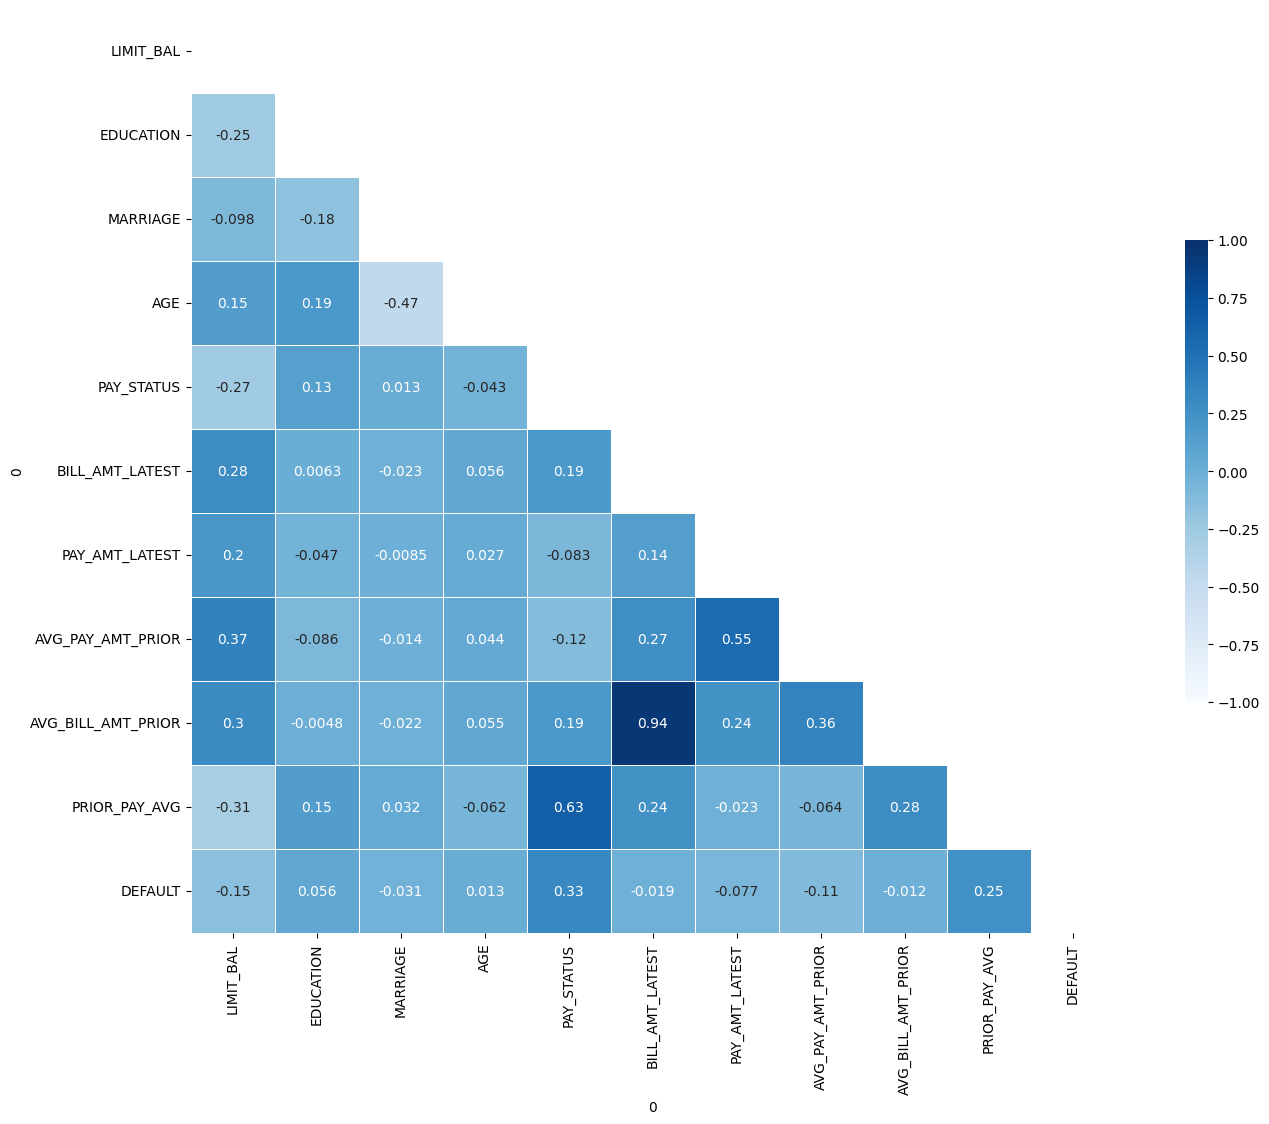

In [60]:
import matplotlib.pyplot as plt 
import seaborn as sns

numeric = ['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_STATUS',
       'BILL_AMT_LATEST', 'PAY_AMT_LATEST', 'AVG_PAY_AMT_PRIOR',
       'AVG_BILL_AMT_PRIOR', 'PRIOR_PAY_AVG', 'DEFAULT']
corr = df[numeric].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18,12))
ax = sns.heatmap(corr, mask=mask, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cmap='Blues', cbar_kws={'shrink': .5}, annot=True, annot_kws={'size': 10})
cbar = ax.collections[0].colorbar
# plt.savefig('images/correlation.svg')

In [62]:
df.columns

Index(['ID', 'LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_STATUS',
       'BILL_AMT_LATEST', 'PAY_AMT_LATEST', 'DEFAULT', 'AVG_PAY_AMT_PRIOR',
       'AVG_BILL_AMT_PRIOR', 'PRIOR_PAY_AVG'],
      dtype='object', name=0)

In [63]:
df.to_csv('../data/final_dataset.csv', index=False)